# ROXSI 2022 SSA Nortek Signature 1000
Visualize Sig1000 data QC and statistical parameters from ROXSI 2022 Asilomar Small-Scale Array measurements.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
import cmocean
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws


In [2]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103063
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory

# Nortek Vector ADVs
data_vec = os.path.join(rootdir, 'Vectors', 'Level1', 'netcdf')
fns_vec = sorted(glob.glob(os.path.join(data_vec, '*Vec*.nc')))


## Read and plot bathymetry
First plot closeups of SSA bathymetry with Signature moorings marked with triangles.

To convert to html:
```
jupyter nbconvert --to html --no-input --template classic bispectrum_tests.ipynb
```

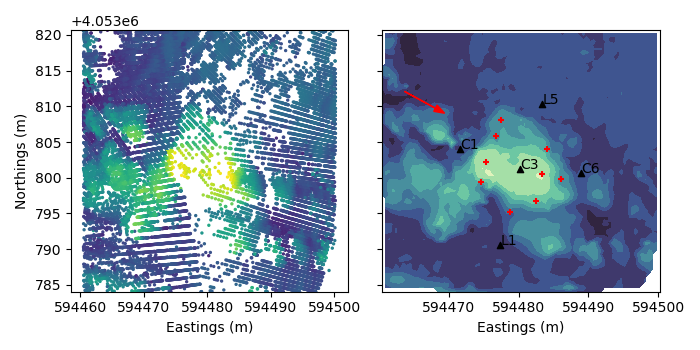

In [7]:
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2, constrained_layout=True,
                         sharey=True)
axes[0].scatter(dsb.x_pts, dsb.y_pts, c=dsb.z_pts, s=2)
axes[0].set_xlabel('Eastings (m)')
axes[0].set_ylabel('Northings (m)')
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
                 cmap=cmocean.cm.deep_r)
# Mooring locations
s = 20 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), 'C1', color='k')
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), 'C3', color='k')
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), 'C6', color='k')
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), 'L1', color='k')
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), 'L5', color='k')
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='r', s=s)

# Arrow showing 298 deg angle (typical wave direction)
x = dsb.C1_utm[0].item() - 8
y = dsb.C1_utm[1].item() + 8
r = 5
angle_met = 298 # Meteorological convention angle
angle_math = (270 - angle_met) # Convert to math conv.
if angle_math < 0:
    angle_math += 360
angle_math = np.deg2rad(angle_math)
axes[1].arrow(x, y, r*np.cos(angle_math), r*np.sin(angle_math), color='r', head_width=1)

axes[1].set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


## Plot rotated grid

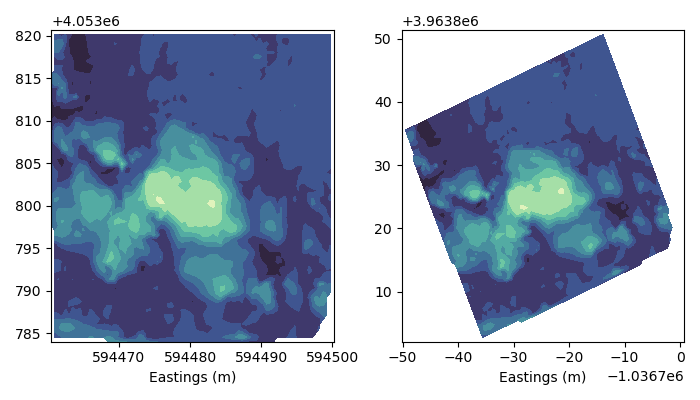

In [8]:
def mg2coords(X, Y, Z):
    return np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

def rotz(rad):
    rad = np.radians(rad)
    sin = np.sin(rad)
    cos = np.cos(rad)
    rot = [[cos, sin, 0],
            [-sin,  cos, 0],
            [0, 0, 1]]
    return np.array(rot)

fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,4), ncols=2, constrained_layout=True)

# Plot original grid
axes[0].contourf(dsb.eastings, dsb.northings, dsb.z_utm, 
                 vmin=-8.0, vmax=-3.5, cmap=cmocean.cm.deep_r)

# Rotate grid
angle_met = 293
magdec = 12.88
angle_math = 270 - angle_met #+ magdec
if angle_math < 0:
    angle_math += 360
xg, yg = np.meshgrid(dsb.eastings.values, dsb.northings.values, indexing='xy')
zg = dsb.z_utm.values
# xrot, yrot, zrot = rpct.rotate_zgrid(xg, yg, zg, np.radians(angle_math))
xrot, yrot = rpct.rotate_xygrid(dsb.eastings.values, dsb.northings.values, np.radians(angle_math))
zrot = dsb.z_utm.values
# Plot rotated grid
axes[1].contourf(xrot, yrot, zrot, vmin=-8.0, vmax=-3.5, cmap=cmocean.cm.deep_r)

for ax in axes:
    ax.set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


## Read Level 1 velocity data
If visualizing all dates, concatenate daily netcdf files into one xr.Dataset.

In [3]:
# Use all available serial numbers
sers = ['103088', '103094', '103110',]# '103063'] #, '103206']
mids = ['C1', 'C3', 'C6', 'L1'] #, 'L5']
spec_key = 'ETAlkrms' # Spectrum heave product
# spec_key = 'ASTd'
# Save mean datasets in dict
dsdv = {} # Velocity datasets
dsds = {} # Spectrum datasets
for ser, mid in zip(sers, mids):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's velocity/spectrum directories
    veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
    specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory
    # List velocity netcdf files for specified serial number
    fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
    # List AST-spectrum netcdf files for specified serial number
    fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))

    dsl = [] # Empty list for concatenating velocity datasets
    dssl = [] # Empty list for concatenating spectrum datasets
    # Iterate over and read files, and append to list for concatenating
    for fnv, fns in tqdm(zip(fns_nc_vel, fns_nc_spec)):
        # Read velocity netcdf
        dsi = xr.decode_cf(xr.open_dataset(fnv, decode_coords='all'))
        # Take 20+min averages
        dsi = dsi.resample(time='20T').mean()
        # Also read spectrum netcdf from AST
        dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
        # Merge Hs, Tm and vel_binh from spectrum file with dsi
        dsi = xr.merge([dsi, dss[['Hm0', 'Te', 'vel_binh', 'Dp_ind']].drop_duplicates(dim='time')])
        dsl.append(dsi) # Append
        dssl.append(dss) # Append

    # Concatenate datasets into one
    ds = xr.concat(dsl, dim='time')
    dsdv[mid] = ds # Save in dict
    dss = xr.concat(dssl, dim='time')
    dsds[mid] = dss # Save in dict


Reading 103088-C1 netcdf files ...


0it [00:00, ?it/s]

Reading 103094-C3 netcdf files ...


0it [00:00, ?it/s]

Reading 103110-C6 netcdf files ...


0it [00:00, ?it/s]

## Plot time series of mean horizontal vs vertical velocity
Depth-averaged velocities.

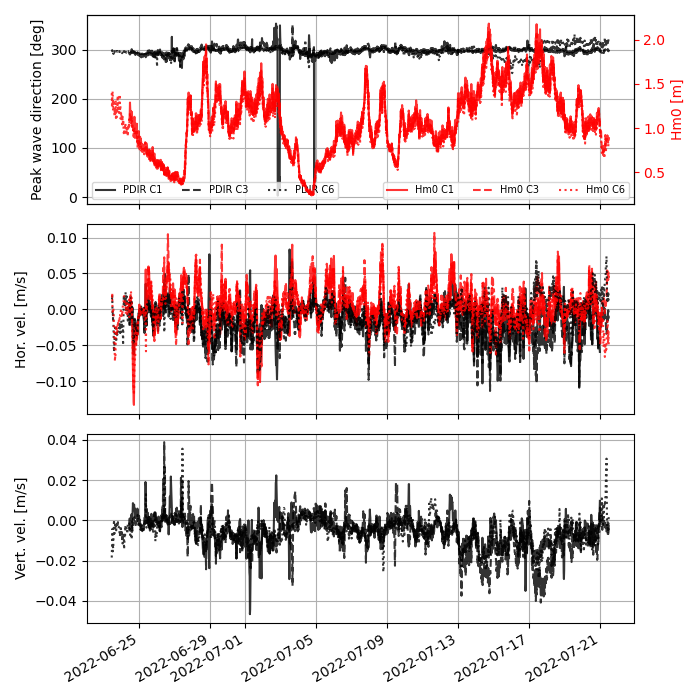

mdir =  298.40997685922474


In [10]:
fig, axes = plt.subplots(figsize=(7,7), nrows=3, sharex=True, constrained_layout=True)
ax2 = axes[0].twinx()
lss = ['-', '--', ':', '-.'] # Linestyles
for i, (ser, mid) in enumerate(zip(sers, mids)):
    ds = dsdv[mid]
    dss = dsds[mid]
    # Plot mean direction on top
    # ds.Dp_ind.plot(ax=axes[0], label='PDIR {}'.format(mid), linestyle=lss[i], 
    dss.mdir.plot(ax=axes[0], label='MDIR {}'.format(mid), linestyle=lss[i], 
        color='k', alpha=0.8)
    axes[0].set_ylabel('Peak wave direction [deg]')
    axes[0].set_xlabel(None)
    # Plot Hm0 on secondary y-axis
    ds.Hm0.plot(ax=ax2, label='Hm0 {}'.format(mid), linestyle=lss[i], color='r', alpha=0.8)
    ax2.set_ylabel('Hm0 [m]', color='r')
    ax2.set_xlabel(None)
    ax2.tick_params(axis='y', colors='red')
    # Plot vertically-avg'd mean horizontal velocities in middle
    ds.vEhpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[1], label='vE {}'.format(mid), linestyle=lss[i], color='k', alpha=0.8)
#     ds.vE.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[1], label='vEn')
    ds.vNhpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[1], label='vN {}'.format(mid), linestyle=lss[i], color='r', alpha=0.8)
#     ds.vN.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[1], label='vNn')
    axes[1].set_ylabel('Hor. vel. [m/s]')
    axes[1].set_xlabel(None)
    # Plot vertically-avg'd mean vertical velocities on bottom
#     ds.vU1hpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[2], label='vU1')
    ds.vU1.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[2], label='vU1', linestyle=lss[i], color='k', alpha=0.8)
#     ds.vU2hpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[2], label='vU2')
#     ds.vU2.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[2], label='vU2n')
    axes[2].set_ylabel('Vert. vel. [m/s]')
    axes[2].set_xlabel(None)

ax2.legend(ncol=3, loc='lower right', fontsize=7)
# axes[1].legend()
# axes[2].legend()

for ax in axes:
    ax.grid()
    ax.legend(ncol=3, loc='lower left', fontsize=7)

plt.tight_layout()
plt.show()
# plt.clf()

# Compute mean wave direction of full data set
mdir = np.mean([dsds['C1'].Dp_ind.mean(), dsds['C3'].Dp_ind.mean(), dsds['C6'].Dp_ind.mean()])
print('mdir = ', mdir)

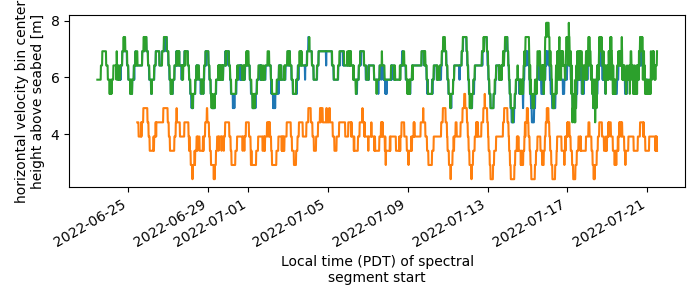

In [4]:
fig, ax = plt.subplots(figsize=(7,3))
for k in ['C1', 'C3', 'C6']:
    dsds[k].vel_binh.plot(ax=ax)
plt.tight_layout()
plt.show()

In [6]:
dsds['C3'].sel(time=pd.Timestamp('2022-06-27 10:20:00'))

<xarray.Dataset>
Dimensions:      (freq: 170, direction: 180, lon: 1, lat: 1)
Coordinates:
  * freq         (freq) float64 0.009789 0.02155 0.03332 ... 1.974 1.986 1.998
  * direction    (direction) int64 2 4 6 8 10 12 14 ... 348 350 352 354 356 358
    time         datetime64[ns] 2022-06-27T10:20:00
  * lon          (lon) float64 -121.9
  * lat          (lat) float64 36.63
Data variables: (12/27)
    Ezz          (freq) float64 0.0009006 0.0009238 ... 4.922e-10 4.639e-10
    Euu          (freq) float64 0.06205 0.02411 0.02708 ... 0.01747 0.01871
    Evv          (freq) float64 0.02661 0.02862 0.02633 ... 0.01668 0.01671
    Efth         (freq, direction) float64 1.049e-06 1.064e-06 ... 8.216e-13
    coh_uz       (freq) float64 0.03798 0.1138 0.09207 ... 0.01396 0.01082
    coh_vz       (freq) float64 0.008039 0.05694 0.04441 ... 0.009281 0.0007725
    ...           ...
    Tp_Y95       float64 12.45
    nu_LH57      float64 0.5311
    Dp_ind       float64 336.0
    Dp_Y95       float64 159.3
    vel_binh     float64 14.42
    water_depth  float64 6.123
Attributes: (12/17)
    title:              ROXSI 2022 Asilomar Small-Scale Array Signature1000 C...
    summary:            Nearshore wave spectra from ADCP measurements. Sea-su...
    instrument:         Nortek Signature 1000
    mooring_ID:         C3
    serial_number:      103094
    transducer_height:  0.3188 m
    ...                 ...
    source:             Sub-surface observation
    date_created:       2023-01-15 19:00:12.791609 UTC
    references:         https://github.com/mikapm/pyROXSI
    creator_name:       Mika P. Malila
    creator_email:      mikapm@unc.edu
    institution:        University of North Carolina at Chapel Hill

## 20-min mean vertical velocities by depth
Non-depth-averaged velocities.

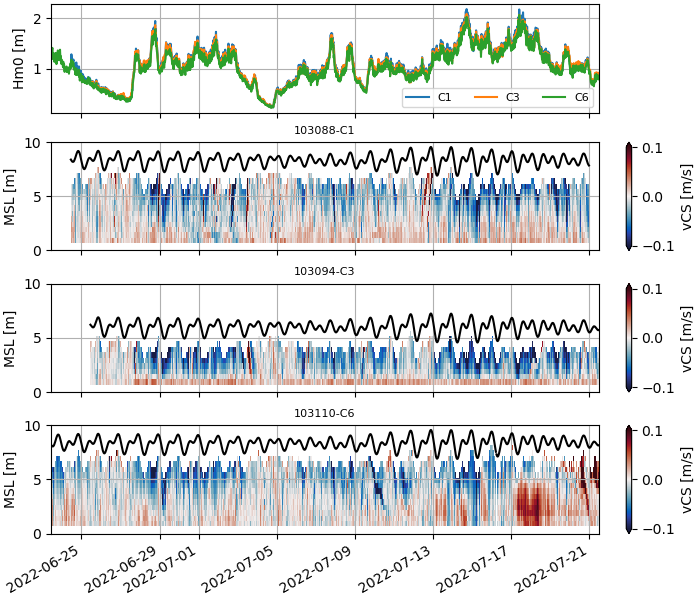

In [9]:
fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True, constrained_layout=True)

# Plot vertically-avg'd mean vertical velocities on bottom
for i, (ser, mid) in enumerate(zip(['103088', '103094', '103110'], ['C1', 'C3', 'C6'])):
    # Plot Hm0 on secondary y-axis
    ds = dsdv[mid]
    dss = dsds[mid]
    ds.Hm0.plot(ax=axes[0], label='{}'.format(mid))
    ds.vE.where(ds.range<=ds.vel_binh).plot.pcolormesh(x='time', y='range', ax=axes[1+i], 
        label=None, cbar_kwargs={'label': 'vCS [m/s]'}, vmin=-0.1, vmax=0.1, 
        cmap=cmocean.cm.balance)
    # Include mean AST surface signal
    ds.z_lin.plot(ax=axes[1+i], label='ASTd {}'.format(mid), color='k') 
    axes[1+i].set_ylim([0, ds.ASTd.max().values + 1.0])
    axes[1+i].set_ylabel('MSL [m]')
    axes[1+i].set_xlabel(None)
    axes[1+i].set_title('{}-{}'.format(ser, mid), fontsize=8)

axes[0].set_ylabel('Hm0 [m]')
axes[0].set_xlabel(None)
axes[0].legend(ncol=3, fontsize=8)
for ax in axes:
    ax.grid()
for ax in axes[1:]:
    ax.set_ylim([0,10])

plt.show()

In [46]:
ds

<xarray.Dataset>
Dimensions:       (time: 1911, range: 28, lon: 1, lat: 1)
Coordinates:
  * range         (range) float64 0.9188 1.419 1.919 2.419 ... 13.42 13.92 14.42
  * lon           (lon) float64 -121.9
  * lat           (lat) float64 36.63
  * time          (time) datetime64[ns] 2022-06-24T11:00:00 ... 2022-07-20T23...
Data variables: (12/32)
    vB1           (time, range) float32 -0.02082 -0.01655 ... 0.03838 0.01692
    vB2           (time, range) float32 -0.0166 -0.002542 ... 0.00766 -0.02573
    vB3           (time, range) float32 -0.01349 0.001145 ... -0.1291 -0.1219
    vB4           (time, range) float32 -0.01376 -0.009855 ... -0.03608 -0.03046
    vB5           (time, range) float64 0.01358 0.0003751 ... -0.02107 -0.01331
    vE            (time, range) float32 -0.007796 -0.02116 ... 0.1662 0.1518
    ...            ...
    ASTd          (time) float64 8.027 7.985 7.945 7.909 ... 7.547 7.509 7.481
    ASTd_eta      (time) float64 3.327e-15 3.607e-15 ... -1.872e-05 0.0004611
    Hm0           (time) float64 1.098 1.153 1.289 1.218 ... 1.098 1.035 1.061
    Te            (time) float64 7.441 7.827 7.711 7.315 ... 5.291 5.283 5.314
    vel_binh      (time) float64 6.419 6.419 5.919 5.919 ... 5.919 5.919 5.919
    Dp_ind        (time) float64 286.5 285.4 285.7 286.6 ... 285.4 284.7 285.8
Attributes: (12/16)
    title:              ROXSI 2022 Asilomar Small-Scale Array Signature1000 d...
    summary:            Nortek Signature 1000 velocity, surface elevation and...
    instrument:         Nortek Signature 1000
    mooring_ID:         C1
    serial_number:      103088
    transducer_height:  0.3188 m
    ...                 ...
    source:             Sub-surface observation
    date_created:       2023-01-04 18:49:29.000217 UTC
    references:         https://github.com/mikapm/pyROXSI
    creator_name:       Mika P. Malila
    creator_email:      mikapm@unc.edu
    institution:        University of North Carolina at Chapel Hill

## C3 Sig1000 vs Vector mean vertical velocities
Compare 20-minute mean vertical velocities from Signature and Vector at C3 mooring.

In [18]:
def nan50_mean(da):
    return da.mean(dim='time').where(
        # da.notnull().sum(dim='time') >= len(da.time)*0.5
        da.notnull().sum(dim='time') >= 8000
    )

# Read vector Level1 netcdf file for mooring C3
serv = '17219' # Serial no. of C3 Vector
fn_vec = [f for f in fns_vec if serv in f]
print('Reading {} ...'.format(os.path.basename(fn_vec[0])))
dsv = xr.decode_cf(xr.open_dataset(fn_vec[0], decode_coords='all'))
t_end = pd.Timestamp('2022-07-25 00:00:00')
dsv = dsv.sel(time=slice(None, t_end))

# Convert despiked xyz velocities to ENU
print('Converting velocities ...')
enu = rpct.uvw2enu(vel=np.array([dsv.uxd.values, dsv.uyd.values, dsv.uzd.values]).T, 
                   heading=dsv.heading_ang.values, pitch=dsv.pitch_ang.values,
                   roll=dsv.roll_ang.values, magdec=12.86)

# Save variables to dataset
dsv['uE'] = (['time'], enu[0,:].copy())
dsv['uN'] = (['time'], enu[1,:].copy())
dsv['uU'] = (['time'], enu[2,:].copy())

# Reindex dataset to full time index
print('Reindexing to full time index ...')
time_ind_full = pd.date_range(dsv.time.isel(time=0).values, dsv.time.isel(time=-1).values,
                              freq='3125ms')
# dsv = dsv.reindex(time=time_ind_full)

# Take 20-minute means of Vector vertical velocity
w_mean = dsv.uU.resample(time='20T').map(nan50_mean) 

Reading Asilomar_SSA_L1_Vec_17219.nc ...
Converting velocities ...
Reindexing to full time index ...


Use lowest velocity bin from signature.

NameError: name 'w_mean' is not defined

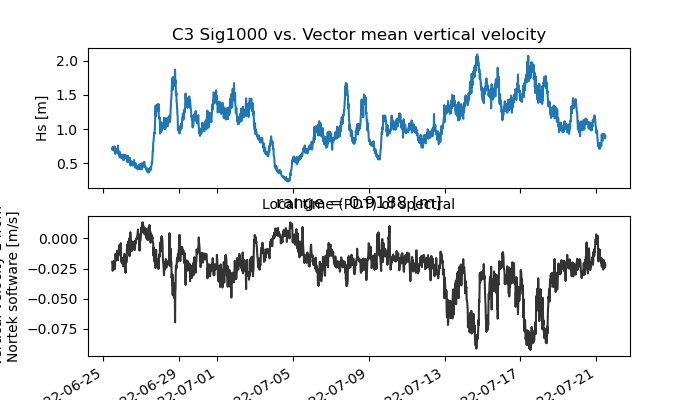

In [10]:
ds = dsdv['C3'] # Signature dataset
dss = dsds['C3'] # Signature dataset

# Plot Signature vs. Vector mean vertical velocities
fig, axes = plt.subplots(figsize=(7,4), nrows=2, sharex=True)

# Hs on top row
dss.Hm0.plot(ax=axes[0], label='Hs (Sig)')
axes[0].set_ylabel('Hs [m]')
axes[0].set_title('C3 Sig1000 vs. Vector mean vertical velocity')

# Vertical velocities on second row
# ds.vU1.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#     ax=axes[1], label='vU1n', color='k', alpha=0.8)
ds.vU1.isel(range=0).plot(ax=axes[1], color='k', alpha=0.8, label='Sig W (bin 1)')
w_mean.plot(ax=axes[1], color='r', marker='.', label='Vec mean(W)', markersize=3, 
    linestyle='none')
axes[1].set_ylabel('Vert. vel. [m/s]')

for ax in axes:
    ax.set_xlabel(None)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

Vector vertical velocity vs. Signature depth-avg. vertical velocity.

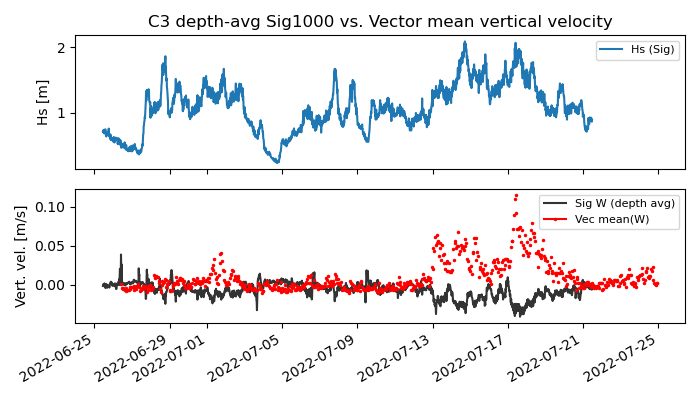

In [20]:
ds = dsdv['C3'] # Signature dataset
dss = dsds['C3'] # Signature dataset

# Plot Signature vs. Vector mean vertical velocities
fig, axes = plt.subplots(figsize=(7,4), nrows=2, sharex=True)

# Hs on top row
dss.Hm0.plot(ax=axes[0], label='Hs (Sig)')
axes[0].set_ylabel('Hs [m]')
axes[0].set_title('C3 depth-avg Sig1000 vs. Vector mean vertical velocity')

# Vertical velocities on second row
ds.vU1.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
    ax=axes[1], label='Sig W (depth avg)', color='k', alpha=0.8)
w_mean.plot(ax=axes[1], color='r', marker='.', label='Vec mean(W)', markersize=3)
axes[1].set_ylabel('Vert. vel. [m/s]')

for ax in axes:
    ax.set_xlabel(None)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## Nortek vs. calculated mean velocities
Compare velocities estimated by Nortek software (vE, vN, vU1, vU2) vs. despiked velocities computed from time series of heading, pitch and roll (vEhpr, vNhpr, vU1hpr, vU2hpr).

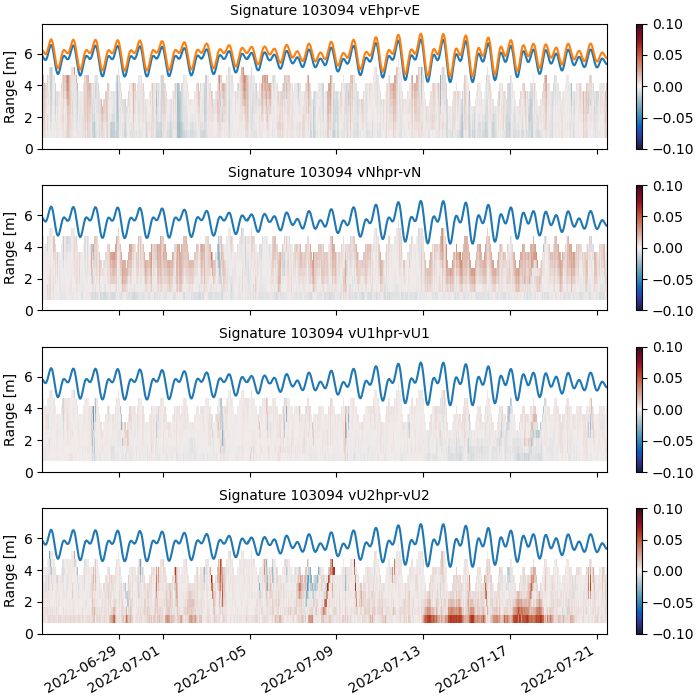

In [5]:
ds = dsdv['C3'] # Signature dataset
dss = dsds['C3'] # Signature dataset

ser = '103094'

# Initialize figure
fig, axes = plt.subplots(figsize=(7,7), nrows=4, sharex=True, sharey=True,
                         constrained_layout=True)
vmin = -0.1
vmax = 0.1
fontsize = 10
# diff of vE on top
(ds.vEhpr - ds.vE).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[0], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vEhpr-vE')
ds.ASTd.plot(ax=axes[0], label='ASTd') # Include mean AST surface signal
ds.z_lin.plot(ax=axes[0], label='z_lin') # Include mean AST surface signal
axes[0].set_title('Signature {} vEhpr-vE'.format(ser), fontsize=fontsize)
# diff of vN in middle
(ds.vNhpr - ds.vN).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[1], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vNhpr-vN')
ds.ASTd.plot(ax=axes[1], label='ASTd') # Include mean AST surface signal
axes[1].set_title('Signature {} vNhpr-vN'.format(ser), fontsize=fontsize)
# diff of vU1 in middle
(ds.vU1hpr - ds.vU1).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[2], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vU1hpr-vU1')
ds.ASTd.plot(ax=axes[2], label='ASTd') # Include mean AST surface signal
axes[2].set_title('Signature {} vU1hpr-vU1'.format(ser), fontsize=fontsize)
# diff of vU2 on bottom
(ds.vU2hpr - ds.vU2).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[3], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vU2hpr-vU2')
ds.ASTd.plot(ax=axes[3], label='ASTd') # Include mean AST surface signal
axes[3].set_title('Signature {} vU2hpr-vU2'.format(ser), fontsize=fontsize)

# Set axis labels and limits
for ax in axes:
    ax.set_ylim([0,ds.ASTd.max().values+1.0])
    ax.set_xlabel('')
    ax.set_ylabel('Range [m]')

plt.show()
# plt.clf()

## Rotate to ROXSI coord. system
Rotate vE and vN velocities to local ROXSI coordinate system where vEr is cross-shore velocity and vNr is alongshore velocity. Use angle of rotation $293^{\circ}$ following the Large-Scale Array convention as well as magnetic declination $12.88^{\circ}$. Vertical velocity is U1 from Nortek software.

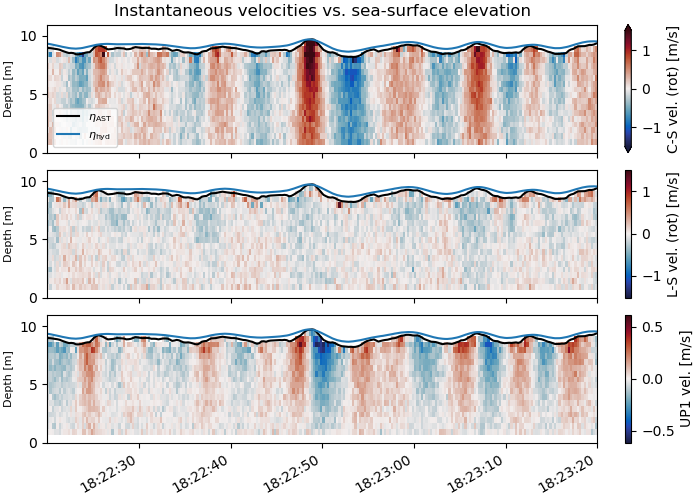

In [13]:
def DoRotation(u, v, rot=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(rot),  np.sin(rot)],
                          [-np.sin(rot), np.cos(rot)]])
    ur = np.cos(rot)*u + np.sin(rot)*v  # "cloclwise"
    vr = -np.sin(rot)*u + np.cos(rot)*v

    #return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([u, v]))
    return RotMatrix @ np.vstack([u, v])
    #return ur, vr

# Read 2022-07-07 dataset and plot
fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[0], decode_coords='all'))

# Rotate E/N velocities to local coordinates
u = dsi.vE.values
v = dsi.vN.values
# Angles
angle_met = 293
magdec = 12.88
angle_math = 270 - angle_met + magdec
if angle_math < 0:
    angle_math += 360
angle_math = np.deg2rad(angle_math)
ul = np.ones_like(dsi.vE.values) * np.nan
vl = np.ones_like(dsi.vN.values) * np.nan
for i,r in enumerate(dsi.range.values):
    u = dsi.vE.sel(range=r).values.copy()
    v = dsi.vN.sel(range=r).values.copy()
    ul[:,i], vl[:,i] = DoRotation(u, v, angle_math)
dsi['vEr'] = (['time', 'range'], ul)
dsi['vNr'] = (['time', 'range'], vl)


# Plot specified time period
t0 = pd.Timestamp('2022-06-24 18:20:00')
t1 = pd.Timestamp('2022-06-24 18:40:00')
# Zoom in timestamps
t0z = pd.Timestamp('2022-06-24 18:22:20')
t1z = pd.Timestamp('2022-06-24 18:23:20')
# Get vmin, vmax for horizontal velocities
vEmax = dsi['vEr'].sel(time=slice(t0,t1)).quantile(0.995).values
vNmax = dsi['vNr'].sel(time=slice(t0,t1)).quantile(0.995).values
vmax = np.max((vEmax, vNmax))
vmin = -vmax
# Get vmin, vmax for vertical vel.
vU1max = dsi['vU1'].sel(time=slice(t0,t1)).quantile(0.995).values

# Initialize figure
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, sharey=True, 
                         constrained_layout=True)
# dsi.sel(time=slice(t0, t1)).vEhpr.plot.pcolormesh(x='time', y='range', ax=axes[0], 
#                                                   label='vEhpr')
# Cross-shore velocity vEr
dsi.sel(time=slice(t0z, t1z)).vEr.where(dsi.range<dsi.ASTd).plot.pcolormesh(x='time', y='range', 
    ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance,
    cbar_kwargs={'label': 'C-S vel. (rot) [m/s]'})
dsi.sel(time=slice(t0z, t1z)).ASTd.plot(ax=axes[0], color='k', label=r'$\eta_{\mathrm{AST}}$')
dsi.sel(time=slice(t0z, t1z)).z_hyd.plot(ax=axes[0], color='C0', label=r'$\eta_{\mathrm{hyd}}$')
axes[0].set_ylabel('Depth [m]', fontsize=8)
axes[0].set_title('Instantaneous velocities vs. sea-surface elevation')
axes[0].legend(fontsize=8)
# Along-shore velocity vNr
dsi.sel(time=slice(t0z, t1z)).vNr.where(dsi.range<dsi.ASTd).plot.pcolormesh(x='time', y='range', 
    ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance,
    cbar_kwargs={'label': 'L-S vel. (rot) [m/s]'})
dsi.sel(time=slice(t0z, t1z)).ASTd.plot(ax=axes[1], color='k')
dsi.sel(time=slice(t0z, t1z)).z_hyd.plot(ax=axes[1], color='C0')
axes[1].set_ylabel('Depth [m]', fontsize=8)
# Vertical velocity vU1
dsi.sel(time=slice(t0z, t1z)).vU1hpr.where(dsi.range<dsi.ASTd).plot.pcolormesh(x='time', 
    y='range', ax=axes[2], vmin=-vU1max, vmax=vU1max, cmap=cmocean.cm.balance,
    cbar_kwargs={'label': 'UP1 vel. [m/s]'})
dsi.sel(time=slice(t0z, t1z)).ASTd.plot(ax=axes[2], color='k')
dsi.sel(time=slice(t0z, t1z)).z_hyd.plot(ax=axes[2], color='C0')
axes[2].set_ylabel('Depth [m]', fontsize=8)
axes[2].set_xlabel(None)
for ax in axes[:2]:
    ax.set_ylim([0,dsi.ASTd.max()+1.0])
    ax.set_xlabel(None)

plt.show()


Plot non-averaged vertical velocities from C3 Signature (bin 7) vs. C3 Vector for 2022-07-17 10:00-10:20, ie. the time period with the highest mean vertical velocity from the Vector and simultaneously one of the lowest mean vertical velocities from the signature.


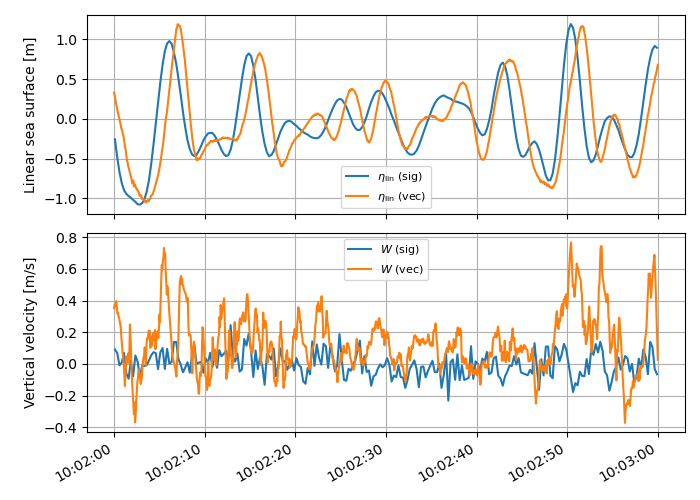

In [41]:
# Signature vs. Vector vertical velocity
t0 = pd.Timestamp('2022-07-17 10:02:00')
t1 = pd.Timestamp('2022-07-17 10:03:00')
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[22], decode_coords='all'))
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True)
dsi.eta_lin.sel(time=slice(t0, t1)).plot(ax=axes[0], label=r'$\eta_\mathrm{lin}$ (sig)')
dsv.eta_lin.sel(time=slice(t0, t1)).plot(ax=axes[0], label=r'$\eta_\mathrm{lin}$ (vec)')
axes[0].set_ylabel('Linear sea surface [m]')
axes[0]
dsi.vU1.sel(time=slice(t0, t1)).isel(range=0).plot(ax=axes[1], label=r'$W$ (sig)')
dsv.uU.sel(time=slice(t0, t1)).plot(ax=axes[1], label=r'$W$ (vec)')
axes[1].set_ylabel('Vertical velocity [m/s]')

for ax in axes:
    ax.set_xlabel(None)
    ax.grid()
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [38]:
dsv

<xarray.Dataset>
Dimensions:      (time: 13171200, lat: 1, lon: 1)
Coordinates:
  * lat          (lat) float64 36.63
  * lon          (lon) float64 -121.9
  * time         (time) datetime64[ns] 2022-06-26T10:00:03.031250 ... 2022-07...
Data variables: (12/15)
    ux           (time) float64 ...
    uy           (time) float64 ...
    uz           (time) float64 ...
    uxd          (time) float64 ...
    uyd          (time) float64 ...
    uzd          (time) float64 ...
    ...           ...
    heading_ang  (time) float64 ...
    pitch_ang    (time) float64 ...
    roll_ang     (time) float64 ...
    uE           (time) float64 -0.00596 -0.06299 -0.05302 ... 0.1584 0.2306
    uN           (time) float64 -0.01707 -0.001774 0.01216 ... -0.235 -0.2413
    uU           (time) float64 -0.03304 -0.02422 -0.02052 ... 0.05204 0.03138
Attributes: (12/37)
    title:                               ROXSI 2022 Asilomar Small-Scale Arra...
    summary:                             Nearshore acoustic doppler velocimet...
    instrument:                          Nortek Vector ADV
    mooring_ID:                          C3VP02
    burst_length:                        1200 seconds
    deployment_time:                     6/25/2022 6:00:00 AM
    ...                                  ...
    source:                              Sub-surface observation
    date_created:                        2022-11-04 20:33:30.146485 UTC
    references:                          https://github.com/mikapm/pyROXSI
    creator_name:                        Mika P. Malila
    creator_email:                       mikapm@unc.edu
    institution:                         University of North Carolina at Chap...

Plot non-averaged vertical velocities from C3 Signature (bin 7) vs. C3 Vector for 2022-06-26 18:00-18:20. Here the phasing between surface elevation and W seems more normal also for the signature.

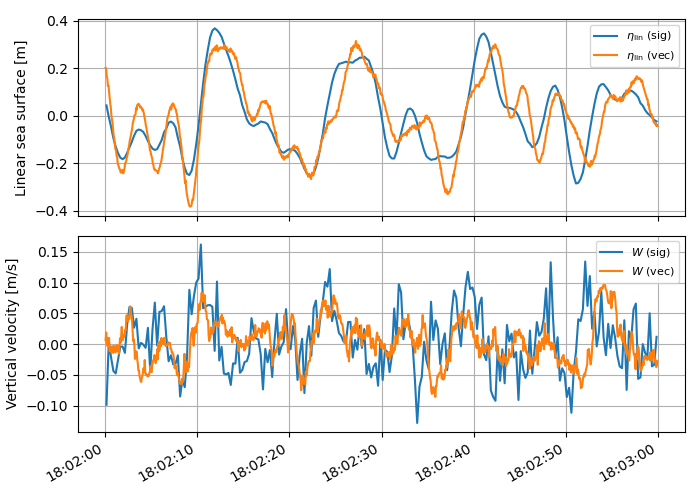

In [15]:
# Signature vs. Vector vertical velocity
t0 = pd.Timestamp('2022-06-26 18:02:00')
t1 = pd.Timestamp('2022-06-26 18:03:00')
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[2], decode_coords='all'))
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True)
dsi.eta_lin.sel(time=slice(t0, t1)).plot(ax=axes[0], label=r'$\eta_\mathrm{lin}$ (sig)')
dsv.eta_lin.sel(time=slice(t0, t1)).plot(ax=axes[0], label=r'$\eta_\mathrm{lin}$ (vec)')
axes[0].set_ylabel('Linear sea surface [m]')
dsi.vU1hpr.sel(time=slice(t0, t1)).isel(range=6).plot(ax=axes[1], label=r'$W$ (sig)')
dsv.uU.sel(time=slice(t0, t1)).plot(ax=axes[1], label=r'$W$ (vec)')
axes[1].set_ylabel('Vertical velocity [m/s]')

for ax in axes:
    ax.set_xlabel(None)
    ax.grid()
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

Maybe there is something strange going on with the instrument orientations at the end of the experiment? Plot heading, pitch and roll time series from C3 vector vs. C3 signature.

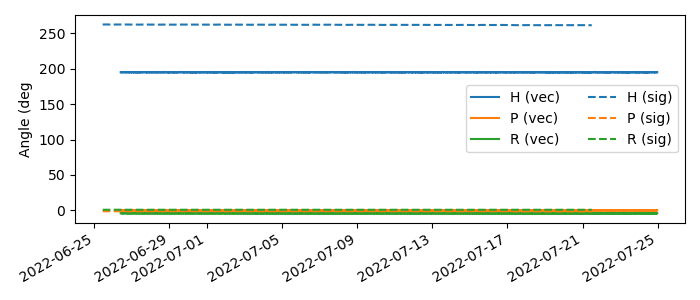

In [16]:
# Plot H,P,R comparison between C3 signature and vector
fig, ax = plt.subplots(figsize=(7,3))
dsv.heading_ang.resample(time='20T').mean().plot(ax=ax, color='C0', label='H (vec)')
dsv.pitch_ang.resample(time='20T').mean().plot(ax=ax, color='C1', label='P (vec)')
dsv.roll_ang.resample(time='20T').mean().plot(ax=ax, color='C2', label='R (vec)')
dsdv['C3'].heading_ang.plot(ax=ax, color='C0', linestyle='--', label='H (sig)')
dsdv['C3'].pitch_ang.plot(ax=ax, color='C1', linestyle='--', label='P (sig)')
dsdv['C3'].roll_ang.plot(ax=ax, color='C2', linestyle='--', label='R (sig)')

ax.legend(ncol=2)
ax.set_ylabel('Angle (deg')
ax.set_xlabel(None)

plt.tight_layout()
plt.show()
# plt.clf()

## Coherence and phase of velocities
Same example time series as above.

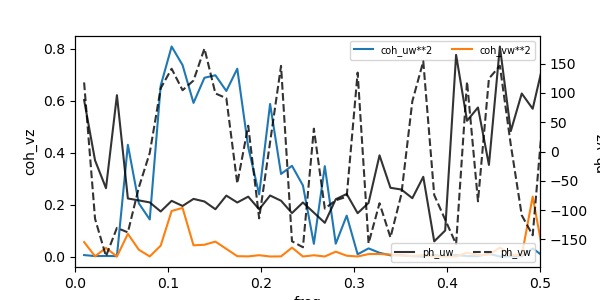

In [26]:
fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[0], decode_coords='all'))
# Rotate E/N velocities to local coordinates
u = dsi.vE.values
v = dsi.vN.values
# Angles
angle_met = 293
magdec = 12.88
angle_math = 270 - angle_met + magdec
if angle_math < 0:
    angle_math += 360
angle_math = np.deg2rad(angle_math)
ul = np.ones_like(dsi.vE.values) * np.nan
vl = np.ones_like(dsi.vN.values) * np.nan
for i,r in enumerate(dsi.range.values):
    u = dsi.vE.sel(range=r).values.copy()
    v = dsi.vN.sel(range=r).values.copy()
    ul[:,i], vl[:,i] = DoRotation(u, v, angle_math)
dsi['vEr'] = (['time', 'range'], ul)
dsi['vNr'] = (['time', 'range'], vl)

# Compute coherence and phase of rotated velocities
t0 = pd.Timestamp('2022-06-24 18:20:00')
t1 = pd.Timestamp('2022-06-24 18:40:00')
z = dsi.vU1.sel(time=slice(t0, t1)).isel(range=5).values.astype(np.float32)
u = dsi.vE.sel(time=slice(t0, t1)).isel(range=5).values
v = dsi.vN.sel(time=slice(t0, t1)).isel(range=5).values
spec = rpws.spec_uvz(z=z, u=u, v=v, fs=4)
zr = dsi.vU1.sel(time=slice(t0, t1)).isel(range=5).values.astype(np.float32)
ur = dsi.vEr.sel(time=slice(t0, t1)).isel(range=5).values
vr = dsi.vNr.sel(time=slice(t0, t1)).isel(range=5).values
spec_r = rpws.spec_uvz(z=zr, u=ur, v=vr, fs=4)

fig, ax = plt.subplots(figsize=(6,3))
ax1 = ax.twinx()
# (spec.coh_uz**2).plot(ax=ax)
(spec_r.coh_uz**2).plot(ax=ax, label='coh_uw**2')
(spec_r.coh_vz**2).plot(ax=ax, label='coh_vw**2')
# np.rad2deg(spec.ph_uz).plot(ax=ax1, color='k', alpha=0.8)
np.rad2deg(spec_r.ph_uz).plot(ax=ax1, label='ph_uw', color='k', linestyle='-', alpha=0.8)
np.rad2deg(spec_r.ph_vz).plot(ax=ax1, label='ph_vw', color='k', linestyle='--', alpha=0.8)

ax.legend(loc='upper right', ncol=4, fontsize=7)
ax1.legend(loc='lower right', ncol=4, fontsize=7)
# Set x limits
ax.set_xlim([0, 0.5])

plt.show()

## Test coherence & phase
Use synthetic signals to test coherence and phase calculation in rpws.spec_uvz(). Test case borrowed from https://currents.soest.hawaii.edu/ocn_data_analysis/_static/Spectrum_cross.html

The phase (black dots) at peak squared coherence (blue dashed) should be 90 deg. The phase should have a linear trend with frequency.

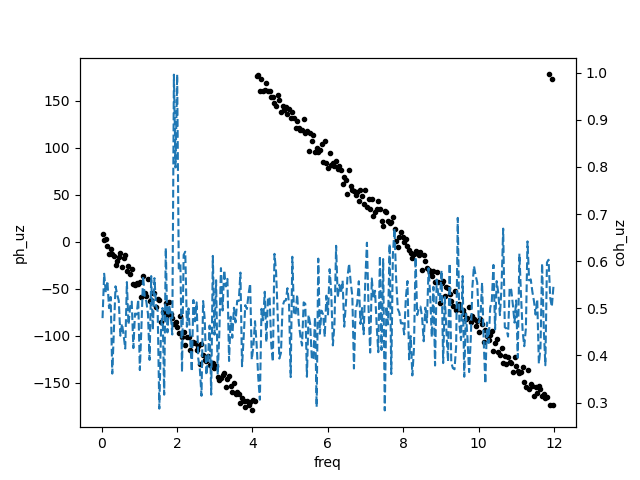

In [27]:
def datafaker(nt, dt=1, freqs=None, color='w',
              amp=1, 
              complex=True,
              repeatable=True):
    """
    Generate fake data with optional sinusoids (all the
    same amplitude) and with red, white, or blue noise
    of arbitrary amplitude.
    
    *nt* : number of points
    *dt* : time increment in arbitrary time units
    *freqs* : None, or a sequence of frequencies in
        cycles per unit time. 
    *color* : 'r', 'w', 'b'
    *amp* : amplitude of red, white, or blue noise
    *complex* : True, False
    *repeatable* : True, False

    Returns t, x
    """
    if repeatable:
        np.random.seed(1)    
    noise = np.random.randn(nt + 1) + 1j * np.random.randn(nt + 1)
    
    if color == 'r':
        noise = np.cumsum(noise) / 10 
        noise -= noise.mean()
    elif color == 'b':
        noise = np.diff(noise)
    noise = noise[:nt]
    x = amp * noise

    t = np.arange(nt, dtype=float) * dt
    
    for f in freqs:
        sinusoid = np.exp(2 * np.pi * 1j * f * t)
        x += sinusoid
    if not complex:
        x = np.real(x)
        
    return t, x

def three_series(n_shift, nt, dt=1, freqs=None,
                 amp=1, 
                 complex=True,
                 repeatable=True):
    if repeatable:
        np.random.seed(100)
    # shared random part    
    noise = 1.5 * amp * np.random.randn(nt + n_shift)
    # shared harmonic behavior
    t0, s0 = datafaker(nt + n_shift, dt=dt, freqs=freqs,
                       amp=0, complex=complex)
    t = t0[:-n_shift]
    s1 = s0[n_shift:] + noise[n_shift:] + amp * np.random.randn(nt)
    s2 = s0[:-n_shift] + noise[:-n_shift] + amp * np.random.randn(nt)
    s3 = s0[:-n_shift] + noise[:-n_shift] + amp * np.random.randn(nt)

    s1 -= s1.mean()
    s2 -= s2.mean()
    s3 -= s3.mean()
    return t, s1, s2 * 1.5, s3 * 1.5

t, x1, x2, x3 = three_series(3, 28800, freqs=[1/12.42, 1/12],
                             amp=0.5,
                             complex=False,
                             repeatable=False)

fs = 24
dt = 1 / fs
sp = rpws.spec_uvz(z=x1, u=x2, v=x3, fs=fs, fmerge=11)

fig, ax = plt.subplots()
ax1 = ax.twinx()
np.rad2deg(sp.ph_uz).plot(ax=ax, color='k', marker='.', linestyle='none')
(sp.coh_uz**1).plot(ax=ax1, linestyle='--',)
plt.show()
# plt.clf()

In [7]:
dss = dsds['C3'] # Signature dataset

dss.mdir.max()

<xarray.DataArray 'mdir' ()>
array(282.516176)